# On the Use of Bubble Detectors at Laser-Driven Neutron Sources

This notebook bundles the functions and analysis scripts developed for the analysis of bubble detectors. 
The code is licensed under Attribution 4.0 International.

Contributors include (alphabetically):
* S. Scheuren
* B. Schmitz

Content of the Notebook

* [Sec 1 Import modules](#import)
* [Sec 2 Function Definitions](#Defs)
  * [Calculate $c_\text{eff}$](#Def_Ceff)
  * [Calculate relative uncertainty of $c_\text{eff}$](#Def_ceff_sigma)
  * [Correction of the statistival variance of the sensitivity](#Def_s_stat)
  * [Calculate neutron yield and uncertainty in neutron number](#Def_n_count)
  * [Stitching data sets together](#Def_temperature_data)
  * [Save plots](#Def_save_plots)
* [Sec 3 Evaluation Part](#Begin_Eval)
  * [Import necessary data to calculate correction terms for analysis of experimental data](#Data_Import)
    * [1) Load data from publications for corrections](#Load_Data)
    * [2) Load and prepare Monte Carlo data](#Load_MC)
    * [3) Load and plot pre-trained surrogate model for $c(E_n)$](#Load_Surrogate)
    * [4) Plot surrogate](#Plot_surrogat)
    * [5) Calculate weighted calibration factor, $c_\text{eff}(E_n)$](#Calc_ceff)
    * [6) Calculate correction for statistical variance of BD sensitivity](#Calc_s_correction)
    * [7) Calculate correction function for temperature dependent sensitivity](#Calc_Temp_Corr)
  * [Read in experimental data from different beamtimes](#Read_Exp_Data)
  * [Plotting of neutron numbers and uncertainty](#Load_MC)
  * [Comparison to old method](#Comparison)
  * [Uncertainty Quantification](#Calc_UQ)

## 1 Import modules <a class="anchor" id="import"></a>


In [1]:
# Import for interactive plotting in VSC
#%matplotlib widget

# General imports
import os
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.constants as co
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter
import numpy.polynomial.polynomial as poly

# Specific imports for functions
# -> fitting, interpolation and S-to-N determination
from sklearn import metrics
import scipy.optimize as opt
import scipy.interpolate as interp


# Set fontsize for plots
fs = 15
fs_tick = 14 
fs_legend = 13

## 2 Function Definitions <a class="anchor" id="Defs"></a>
In the following section the needed functions are defined. 


### Function to calculate $c_\text{eff}$ and its derivative $\frac{\partial c_\text{eff}}{\partial E}$ <a class="anchor" id="Def_Ceff"></a>

In [2]:
def c_eff(n_energy, dNdE_spectrum, c_model_values):
    """
    This function calculates the effective value for c used in the new methodology.
    The calculation is based on an input (normalized) neutron spectrum and the response curve of the Bubble Detectors.

    Parameters
    ----------
    n_energy : one dimensional numpy ndarray of shape (k,)
        Neutron energy grid, with linear spacing.
    dNdE_spectrum : one dimensional numpy ndarray of shape (k,)
        Normalized differential neutron spectrum dN/dE in n/MeV, corresponding to the energy grid n_energy. 
        Length must be equal to length of n_energy.
    c_model_values : one dimensional numpy ndarray of shape (k, 1)
        Reconstructed response function of the Bubble Detectors. Based on the logarithmic surrogate reconstruction.

    Returns
    -------
    c_value_return : float
        Returns c effective for the conversion of bubble count to neutron number

    """
    c_model_values = 10**c_model_values
    c_value_return = metrics.auc(n_energy, dNdE_spectrum * c_model_values.reshape(-1))
    return c_value_return


def ddE_c_eff(n_energy, dNdE_spectrum, c_model_values, c_model_derivative):
    """
    This function calculates the first derivative of c effective with respect to the neutron energy.
    The derivative is needed later on to determine the uncertainty of the calculated neutron number from a given bubble count.

    Parameters
    ----------
    n_energy : one dimensional numpy ndarray of shape (k,)
        Neutron energy grid, with linear spacing.
    dNdE_spectrum : one dimensional numpy ndarray of shape (k,)
        Normalized differential neutron spectrum dN/dE in n/MeV. Length must be equal to length of n_energy
    c_model_values : one dimensional numpy ndarray of shape (k, 1)
        Reconstructed response function of the Bubble Detectors. Based on the logarithmic surrogate reconstruction.
    c_model_derivative : one dimensional numpy ndarray of shape (k, 1)
        First derivative with respect to neutron energy of the Bubble Detector response function, obtained from the surrogate model.

    Returns
    -------
    c_deriv_return : Float
        Returns first derivative of c effective with respect to the neutron energy.

    """
    c_data_derivative = c_model_derivative/n_energy.reshape(-1, 1) * 10**c_model_values
    c_deriv_return = metrics.auc(n_energy, dNdE_spectrum * c_data_derivative.reshape(-1))
    return c_deriv_return

### Calculate relative uncertainty of $\Delta = \frac{\Delta c_\text{eff}}{c_\text{eff}}$, based on the inputs of the function <a class="anchor" id="Def_ceff_sigma"></a>

In [3]:
def delta_c_eff(dNdE_spectrum, dNdE_rel_err, c_model_values, c_model_variance):
    """
    This function determines the uncertainty for c_eff, which is needed to determine the uncertainty in neutron number.

    Parameters
    ----------
    dNdE_spectrum : one dimensional numpy ndarray of shape (k,)
        Normalized differential neutron spectrum dN/dE in n/MeV. Length must be equal to length of n_energy
    dNdE_rel_err : one dimensional numpy ndarray of shape (k,)
        Relative uncertainty for each energy bin of the neutron spectrum used in the calculation of c_eff.
        Length must be equal to length of spectrum_norm.
    c_model_values : one dimensional numpy ndarray of shape (k, 1)
        Reconstructed response function of the Bubble Detectors. Based on the logarithmic surrogate reconstruction.
    c_model_variance : one dimensional numpy ndarray of shape (k, 1)
        Variance of each reconstructed value for the response function of Bubble Detectors. Determined from surrogate model.

    Returns
    -------
    sigma_total_rel_return : Float
        Relative uncertainty for c_eff

    """
    c_model_values = 10**c_model_values
    c_model_norm = np.sum(c_model_values)    
    c_var = 10**(np.sqrt(c_model_variance))

    # Uncertainty contribution from Monte Carlo
    sigma_mc = (dNdE_spectrum * dNdE_rel_err)**2
    # Uncertainty contribution from surrogate model
    sigma_sm = ((c_model_values/c_model_norm) * c_var)**2
    sigma_sm = sigma_sm.reshape(-1)


    sigma_total_rel_return = np.sqrt(np.sum((sigma_mc + sigma_sm)))
    return sigma_total_rel_return

### Function for correcting the statistival variance of the sensitivity <a class="anchor" id="Def_s_stat"></a>

In [4]:
def sensitivity_uncert(data_in, ib=1, plot=False):
    """
    This function evaluates the sensitivities uncertainty of the bubble detectors. 
    It returns a term to correct the quoted sensitivity of a Bubble Detector plus the uncertainty in multiples of the standard deviation.

    Parameters
    ----------
    data_in : pandas DataFrame
        DataFrame containing data on the quoted vs measured sensitivtiy in sensitivity quoted/sensitivity measured. 
    ib : Integer, optional
        Set the uncertainty range in terms of the standard deviation sigma. The default is 1, meaning 1 sigma.
    plot : Bool, optional
        Switch to allow plotting of the data and analysis. The default is False.

    Returns
    -------
    1/sens_mean : Float
        Value to correct the quoted sensitivity of a Bubble Detector
    ib*std : Float
        Uncertainty of the returned correction term in integer mutliples of the standard deviation. Default is 1 sigma.

    """
    sens_mean = np.mean(data_in['Sensitivity deviation'])
    print(f"Mean: {round(sens_mean, 3)}")

    std = np.std(data_in['Sensitivity deviation'])
    print(f"Standard deviation {ib} Sigma: {round(ib * std, 3)}")
    sigma_low = sens_mean - ib * std
    sigma_high = sens_mean + ib * std

    if plot:
        fig_sens = plt.figure(figsize=(1.5 * 13.5 / 2.54, 1.0 * 13.5 / 2.54))
        plt.tick_params(labelsize=fs_tick)

        plt.plot(data_in['BD Number'], data_in['Sensitivity deviation'], marker="d", linestyle="none", label="Data")
        plt.hlines(sens_mean, 0, 41, color="tab:orange", linestyle="--", label="Mean")
        fill_x = np.arange(0, 42)
        plt.fill_between(fill_x, sigma_low, sigma_high, alpha=0.25, color="tab:green", label=f"$\pm {ib}\sigma$")
        plt.ylabel("S quoted/S measured", fontsize=fs)
        plt.xlabel("BD number", fontsize=fs)
        plt.legend(loc=2,fontsize=fs_legend)
        plt.show()
    return 1/sens_mean, ib*std

### Functions to calculate neutron yield and uncertainty in neutron number <a class="anchor" id="Def_n_count"></a>

In [5]:
def bubbles2neutrons(b, d, c, s0, temp_corr=1):
    """
    Converson of counted bubbles to neutron number per sr.

    Parameters
    ----------
    b : Integer
        Number of counted bubbles.
    d : Float
        Distance between the Bubble Detector and neutron source in cm.
    c : Float
        Calibration factor of the Bubble Detector. Here it is determined/given by c_eff.
    s0 : Float
        Sensitivity quoted by the manufacturer in bubbles/mrem, written on the Bubble detector.
    temp_corr : Float, optional
        Temperature dependent correction to the sensitivity of the Bubble Detector. 
        Depends on the temperature of the measurement environment.
        The default is 1, meaning no correction is applied.

    Returns
    -------
    neutron_count : Float
        Returns the neutron number per sr.

    """
    neutron_count = b * d**2/(c * s0*temp_corr)
    return neutron_count


def uncertainty_bubbles(b, d_b, d, d_d, s0, ds0, temp_corr=1, deriv_temp_corr=0, 
                        d_T=0, c=3e-5, deriv_c=0, d_c=0.4e-5, d_E=0, 
                        perfect_cts=False, uncerts_tot_out=False, print_out=False):
    """
    Calculate uncertainty for the conversion of counted bubbles to neutron number per sr.

    Parameters
    ----------
    b : Integer
        Number of counted bubbles.
    d_b : Integer
        Uncertainty in the number of counted bubbles.
    d : Float
        Distance between the Bubble Detector and neutron source in cm. 
    d_d : Float
        Uncertainty of distance measurement in cm.
    s0 : Float
        Sensitivity quoted by the manufacturer in bubbles/mrem, written on the Bubble detector.
    ds0 : Float
        Uncertainty in sensitivity of bubbles, usually 10% of the sensitivity, see https://doi.org/10.1016/S1350-4487(00)00154-2 .
    temp_corr : Float, optional
        Temperature dependent correction to the sensitivity of the Bubble Detector. 
        Needs to be given for the temperature at which the measurement was conducted. 
        The default is 1, meaning no correction is applied.
    deriv_temp_corr : Float, optional
        First derivative with respect to temperature of the temperature dependent sensitivity function. 
        Needs to be given for temperature at which the measurement was conducted. 
        The default is 0, meaning its contribution is not considered.
    d_T : Float, optional
        Uncertainty in the temperature of the measurement environment. 
        The default is 0, meaning its contribution is not considered.
    c : Float, optional
        Calibration curve taken from https://doi.org/10.1016/S1350-4487(96)00156-4. 
        The default is the legacy value of 3e-5.
    deriv_c : Float, optional
        First derivative of c with respect to the neutron energy. 
        The default is 0, meaning its contribution is not considered.
    d_c : TYPE, optional
        Uncertainty of calibration curve, taken from the same resource as c. 
        The default is the legacy value of 0.4e-5.
    d_E : Float, optional
        Energy spacing of the linear energy grid n_energy used to calculate c effective, using the function c_eff. 
        The default is 0, meaning its contribution is not considered.
    uncerts_tot_out : Bool, optional
        If set to True, the individual uncertainty terms of eq. XXX are returned in addition to the overall uncertainty term.
        The default is False.
    print_out : Bool, optional
        Allows one to print the individual uncertainty terms of eq. XXX if set to True
        The default is False.

    Returns
    -------
    uncert_return : Float
        Returns the symmetric uncertainty value of the calculated neutron number per sr from Bubble Detector measurments.
        Optionally the individual uncertainty terms of eq. XXX are returned too, as a numpy ndarray.     
    """

    # Define sensitivity with temperature correction factor
    s = s0 * temp_corr
    # Uncertainty for number of bubbles -> delta for counting and delta from Poisson dist
    # Option to assume perfect counting statistics.
    if perfect_cts:
        db = 0
    else:
        db = (d_b + np.sqrt(b))
    dndb = d**2/(c * s) * db  
    # Uncertainty in measurement of distance
    dndd = 2 * b * d/(c * s) * d_d
    # Uncertainty in calibration curve from BTI
    # https://doi.org/10.1016/S1350-4487(96)00156-4
    dndc = -b * d**2/(c**2 * s) * d_c
    # Uncertainty in s0 from published data
    # https://doi.org/10.1016/S1350-4487(00)00154-2
    ds0 = s0 * ds0
    dnds0 = -b * d**2/(c * s0**2 * temp_corr) * ds0
    # Uncertainty in temperature
    dndT = -b * d**2 * d_T/(c * s0 * temp_corr**2) * deriv_temp_corr
    # Energy uncertainty in calibration function
    dndE = -b * d**2 * d_E/(s * c**2) * deriv_c

    if print_out:
        print("Contribution of each term to the squared uncertainty")
        print(f"Bubble number:\n{dndb**2}\n")
        print(f"Distance:\n{dndd**2}\n")
        print(f"Calibration curve:\n{dndc**2}\n")
        print(f"Sensitivity s0:\n{dnds0**2}\n")
        print(f"Temperature:\n{dndT**2}\n")
        print(f"Energy:\n{dndE**2}")
    
    uncert_return = np.sqrt(dndb**2 + dndd**2 + dndc**2 + dnds0**2 + dndT**2 + dndE**2) 
    if uncerts_tot_out:
        return uncert_return, np.array([dndb, dndd, dndc, dnds0, dndE, dndT])
    else:
        return uncert_return

### Function for stitching data sets together <a class="anchor" id="Def_temperature_data"></a>
This is needed for the temperature correction applied to temperature compensated (PND) BDs. 

In [6]:
def stitch_temperature_data(compensated_data, uncompensated_data):
    """
    Extract missing data for lower temperature from the uncompensated dataset. 
    The points are the same below the compensation threshold at around 20°C.

    Parameters
    ----------
    compensated_data : Dataframe (n,2)
        DataFrame for the compensated Temperature Data. First Column: Temperature, Second Column: Normalized Response
    uncompensated_data : Dataframe (m,2)
        DataFrame for the UNcompensated Temperature Data. First Column: Temperature, Second Column: Normalized Response

    Returns
    -------
    compensated_data_export : Dataframe (k,2)
        DataFrame for the compensated Temperature Data joined with lower Temperature Data.

    """
    # First, the compensated_data is lacking information below some Temperature.
    # According to the corresponding publication, the curves are the same below that threshold.
    # The compensated data therefore gets extended with the uncompensated data in that area.
    ## Extract temperature key and find the minimum temperature for the compensated data.
    threshold = np.min(compensated_data.iloc[:,0])
    ## Find all values below the threshold in the uncompensated data.
    threshold_bool = np.where(uncompensated_data.iloc[:,0] <= threshold)[0]
    compensated_data_export = pd.concat([uncompensated_data.iloc[threshold_bool,:], compensated_data], ignore_index=True, sort=False)
    return compensated_data_export 

### Save plots <a class="anchor" id="Def_save_plots"></a>
Checks if file exists and does not overwrite the file

In [7]:
def save_fig(figure, save_fig_name, dpi_in=400, path="./Output/"):
    """
    Calculate uncertainty for neutron number calculated from counted bubbles.

    Parameters
    ----------
    figure : TYPE
        Counted bubble number.
    save_fig_name : TYPE
        Uncertainty in the number of bubbles counted.
    dpi_in : TYPE
        Distance from source in cm. 
    path : TYPE
        Uncertainty of distance measurement in cm.
    
    Returns
    -------
    save_state : TYPE
        0 if save is successfull or 1 if not.
        
    """
    abs_path = path + save_fig_name

    if os.path.exists(abs_path):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!!                                                     !!!")
        print("!!!   You forgot to change the file name! Not Saving!   !!!")
        print("!!!                                                     !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return 1
    else:
        figure.savefig(abs_path, bbox_inches='tight', dpi=dpi_in)
        print("Saved sucessfully!")
        return 0

***

## Evaluation Part <a class="anchor" id="Begin_Eval"></a>
### Import necessary data to calculate correction terms for analysis of experimental data <a class="anchor" id="Data_Import"></a>
#### 1) Load data from publications for temperature and sensitivity corrections<a class="anchor" id="Load_Data"></a>

In [8]:
# Temperature Dependence:
# Data taken from https://doi.org/10.1016/S1350-4487(96)00156-4
## Figure 4
Data_T_Uncompensated  = pd.read_csv('./Data/BTI_Data/Temperature/Temp_Uncompensated.csv')
Data_T_Compensated  = pd.read_csv('./Data/BTI_Data/Temperature/Temp_Compensated.csv')

## Below 20°C compensated BDs show same behavior as uncompensated
## Data_T_Uncompensated < 20°C stitched to Data_T_Compensated
Data_T_Comp_stitch = stitch_temperature_data(compensated_data=Data_T_Compensated, uncompensated_data=Data_T_Uncompensated)


# Data taken from https://doi.org/10.1016/S1350-4487(00)00154-2
## Figure 3 (a) and (b)
Data_Uncert_s0 = pd.read_csv('./Data/BTI_Data/Sensitivity/Sensitivity_s0_STD.csv')

#### 2) Load surrogate model of the response function<a class="anchor" id="Load_Data"></a>

In [9]:
# Load model from pkl file
krg_model = "./Data/Surrogate_Model/BubbleModel_10.pkl"
with open(krg_model, "rb") as f:
    c_sm = pkl.load(f)

Plotting of surrogate model if desired

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0011649
   
   Prediction time/pt. (sec) :  0.0000058
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0207751
   
   Prediction time/pt. (sec) :  0.0001039
   


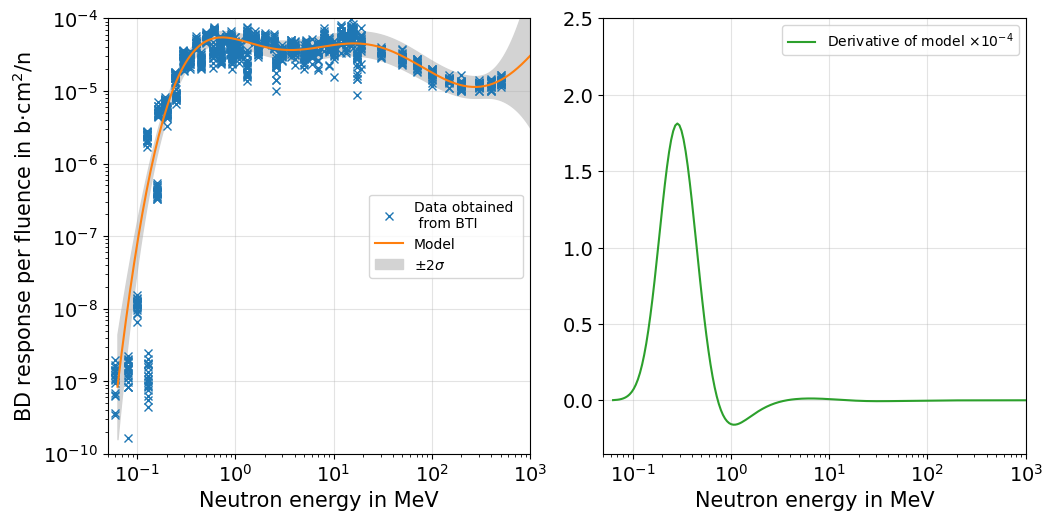

In [10]:
# Plot model in comparison to measured data point and plot its derivative
plot_sm_model = True
if plot_sm_model:
    x_train = c_sm.training_points[None][0][0]
    y_train = c_sm.training_points[None][0][1]

    ndim = 1
    n_samples=200 
    x = np.zeros((n_samples,ndim))
    logss = np.logspace(-1.2, 3, n_samples)
    x[:,0] = np.log10(logss)

    y = c_sm.predict_values(x)
    dy = c_sm.predict_derivatives(x, kx=0)
    var = c_sm.predict_variances(x)

    figc, axsc = plt.subplots(1, 2, figsize=(2.0 * 13.5/2.54, 1.0 * 13.5/2.54), sharex=True, layout="tight")
    axsc[0].tick_params(labelsize=14)
    axsc[1].tick_params(labelsize=14)

    axsc[0].loglog(10**x_train, 10**y_train, "x", label="Data obtained \n from BTI")
    axsc[0].loglog(10**x, 10**y, label="Model")
    axsc[0].fill_between(np.ravel(10**x), np.ravel(10**(y - 2 * np.sqrt(var))), np.ravel(10**(y + 2 * np.sqrt(var))), 
                            color="lightgrey", label="$\pm 2\sigma$")
    axsc[0]. set_xlabel("Neutron energy in MeV", fontsize=fs)
    axsc[0]. set_ylabel("BD response per fluence in b$\cdot$cm$^2$/n", fontsize=fs)
    axsc[0].set_ylim(1e-10, 1e-4)
    axsc[0].set_xlim(5e-2, 1e3)
    axsc[0].legend(loc=5)
    axsc[0].grid(alpha=0.35)

    axsc[1].semilogx(10**x, 1e4/logss.reshape(-1,1) * dy * 10**y, color="tab:green", label="Derivative of model $\\times 10^{-4}$")
    axsc[1].legend(loc="best")
    axsc[1]. set_xlabel("Neutron energy in MeV", fontsize=fs)
    axsc[1].grid(alpha=0.35)
    axsc[1].set_xlim(5e-2, 1e3)
    axsc[1].set_ylim(-0.35, 2.5)
    plt.show()
    # save_fig(figc, "Reconstructed_BD_Response.pdf")

#### 3) Load and prepare Monte Carlo data for calculation of $c_\text{eff}$ <a class="anchor" id="Load_MC"></a>

In [11]:
# Prepare neutron spectra from Monte Carlo simulation
# Load and normalize neutron spectrum
# Chose material: LiF, Be, Cu, Ta
catcher_mc = "LiF"
# Chose angle at which the neutron spectrum is detected: 0° to 180° in 15° steps
angg = "0"
neutron_data_mc = np.loadtxt(open(f"./Data/Monte_Carlo/{catcher_mc}/{angg}deg_lin.cross").readlines()[:-19], 
                                 skiprows=151, usecols=(0,1,2,3), unpack=True)


# Smoothind neutron spectra to minimize influence of fluctiations due to sataistics.
neutron_data_mc[2] = savgol_filter(neutron_data_mc[2], 30, 10)
neutron_data_mc[3] = savgol_filter(neutron_data_mc[3], 30, 10)


# Generate energy grid from mid point of energy bin
e_grid = (neutron_data_mc[0] + neutron_data_mc[1])/2
n_norm_fact = metrics.auc(e_grid, neutron_data_mc[2])
print(n_norm_fact)
# Normalize differential neutron spectrum
dNdE_spectrum_norm = neutron_data_mc[2]/n_norm_fact
# Generate and normalize neutron spectrum
n_spectrum = neutron_data_mc[2] * (neutron_data_mc[1] - neutron_data_mc[0])
n_spectrum_norm = n_spectrum/n_norm_fact

# Get uncertainty from simulation run
spectrum_rel_uncert = neutron_data_mc[3]
# del neutron_data_mc, n_spectrum
print(f"Integral of normalized spectrum: {metrics.auc(neutron_data_mc[1], dNdE_spectrum_norm)}")

3.6581010189912867e-06
Integral of normalized spectrum: 0.9999999999999999


Calculate $c_\text{eff}$ and its uncertainty

In [22]:
# Get data from surrogate model, based on energy grid used in Monte Carlo simulation e_grid
log_e_grid = np.log10(e_grid.reshape(-1, 1))
c_sm_values = c_sm.predict_values(log_e_grid)
c_sm_variances = c_sm.predict_variances(log_e_grid)
c_sm_derivative = c_sm.predict_derivatives(log_e_grid, kx=0)
print("\n \n")

# Calculate weighted calibration factor from calibration function c
c_weighted = c_eff(e_grid, dNdE_spectrum_norm, c_sm_values)
print(f"\nWeighted calibration factor: {round(c_weighted * 1e5, 3)}e-5")

# Calculate uncertainty of calibration function c
deriv_c_weighted = ddE_c_eff(e_grid, dNdE_spectrum_norm, c_sm_values, c_sm_derivative)
print(f"Weighted calibration factor derivative: {round(deriv_c_weighted * 1e7, 3)}e-7")

# Calculate relative uncertainty of c_eff function used in error propagtion
# c_eff_rel_uncert = delta_c_eff(n_spectrum_norm, spectrum_rel_uncert, c_sm_values, c_sm_variances)
c_eff_rel_uncert = delta_c_eff(dNdE_spectrum_norm, spectrum_rel_uncert, c_sm_values, c_sm_variances)
print(f"\n\nRelative uncertainty in calculation of c_eff: {round(c_eff_rel_uncert, 5)}%")
print(f"Absolute uncertainty in calculation of c_eff: {round(c_eff_rel_uncert * c_weighted * 1e5, 3)}e-5")

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 599
   
   Predicting ...
   Predicting - done. Time (sec):  0.0011716
   
   Prediction time/pt. (sec) :  0.0000020
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 599
   
   Predicting ...
   Predicting - done. Time (sec):  0.0854199
   
   Prediction time/pt. (sec) :  0.0001426
   

 


Weighted calibration factor: 4.147e-5
Weighted calibration factor derivative: 49.054e-7


Relative uncertainty in calculation of c_eff: 0.06019%
Absolute uncertainty in calculation of c_eff: 0.25e-5


#### 4) Calculate correction factor for the sensitivity<a class="anchor" id="Load_Data"></a>

Mean: 0.963
Standard deviation 2 Sigma: 0.102


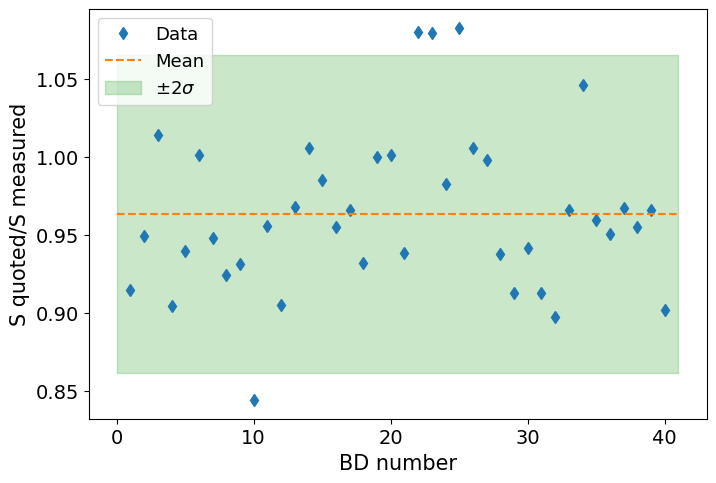

In [13]:
# Calculates correction factor for sensitivity and its standard deviation
# Based on published data
# If wanted 2,3,4,.... sigma environment can be used -> adjust ib
# Use s_corr to adjust quoted sensitivity, which is given in b/mrem
s0_corr, s0_sigma = sensitivity_uncert(Data_Uncert_s0, ib=2, plot=True)

#### 5) Calculate temperature correction<a class="anchor" id="Load_Data"></a>

In [14]:
comp_model = poly.Polynomial.fit(x=Data_T_Comp_stitch.iloc[:,0], y=Data_T_Comp_stitch.iloc[:,1], deg= 2)
uncomp_model = poly.Polynomial.fit(x=Data_T_Uncompensated.iloc[:,0], y=Data_T_Uncompensated.iloc[:,1], deg= 2)
# Polynomial coefficients in order of increasing degree, i.e., (1, 2, 3) give 1 + 2*x + 3*x**2.
comp_derivative = comp_model.deriv(m=1)
uncomp_derivative = uncomp_model.deriv(m=1)

Plotting of the fit function to the temperature dependent sensitivity if desired

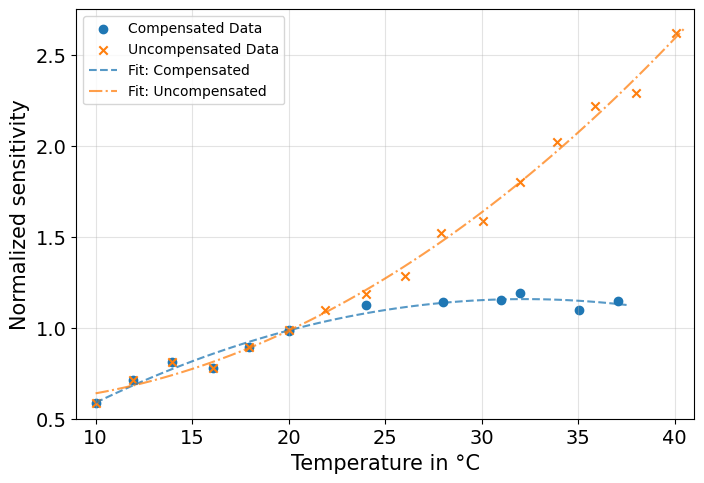

In [15]:
tempplot = True
if tempplot:
    tempf = plt.figure(figsize=(1.5 * 13.5 / 2.54, 1.0 * 13.5 / 2.54))
    plt.tick_params(labelsize=14)

    temp_comp = np.arange(10, 38, 0.5)
    temp_uncomp = np.arange(10, 41, 0.5)

    plt.scatter(Data_T_Comp_stitch.iloc[:,0], Data_T_Comp_stitch.iloc[:,1], label="Compensated Data")
    plt.scatter(Data_T_Uncompensated.iloc[:,0], Data_T_Uncompensated.iloc[:,1], marker="x", label="Uncompensated Data")
    plt.plot(temp_comp, comp_model(temp_comp), linestyle="--", label="Fit: Compensated", alpha=0.75)
    plt.plot(temp_uncomp, uncomp_model(temp_uncomp), linestyle="-.", label="Fit: Uncompensated", alpha=0.75)
    plt.ylabel("Normalized sensitivity", fontsize=fs)
    plt.xlabel("Temperature in °C", fontsize=fs)
    plt.xlim(9, 41)
    plt.ylim(0.5)
    plt.grid(alpha=0.35)
    plt.legend()
    plt.show()
    # save_fig(tempf, "TemperatureCompare.pdf")

### Read in experimental data from beamtime  <a class="anchor" id="Read_Exp_Data"></a>

In [16]:
drc21 = pd.read_excel(f"./Data/Experiment_Data/{catcher_mc}_Draco_2021.ods",  'Sheet1', header=3)
drc21.dropna(how="all", inplace=True)
drc21.fillna(0, inplace=True)

### Calculation and visualization of neutron numbers and uncertainty  <a class="anchor" id="Load_MC"></a>

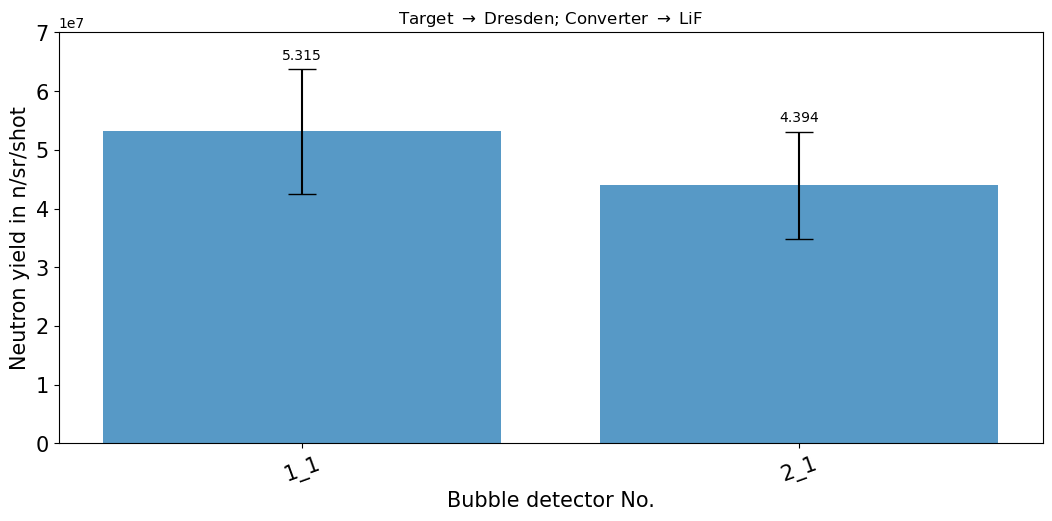

In [17]:
# Cu shots: [1, 2, 3, 4, 6, 10, 11, 12, 13, 16, 17, 22]
# LiF shots: [8, 15, 18, 23]
x_no = 1

if catcher_mc.lower() == "cu":
    if x_no > 8:
        raise Exception("Please select a number from [1,8]!")
elif catcher_mc.lower() == "lif":
    if x_no > 4:
        raise Exception("Please select a number from [1,4]!")


shot = drc21[drc21['Number'] == x_no]



# Temperature at the measurment location in °C
temp = 20
# Apply statistival variance correction to sensitivity (calculated above) of selected shot
shot = shot.assign(s0_corrected=shot['Sensitivity [b/mrem]'] * s0_corr)
# Calculate neutron current per sr from measured bubble count
# b, d, s0 are experimental/quoted data
# c_weighted, temp_corr are correction from the models above
n = bubbles2neutrons(b=shot['Bubbles'], d=shot['Distance [cm]'], 
    c=c_weighted, s0=shot['s0_corrected'], temp_corr=comp_model(temp))

# Calculate uncertainty of neutron current per sr retrieved from measured bubble count
# delta_c_weighted = 0
delta_c_weighted = c_eff_rel_uncert * c_weighted
dn, dn_contribs = uncertainty_bubbles(b=shot['Bubbles'], d_b=shot['Delta Bubbles'], 
    d=shot['Distance [cm]'], d_d=3, s0=shot['s0_corrected'], ds0=s0_sigma,
    temp_corr=comp_model(temp), deriv_temp_corr=comp_derivative(temp), d_T=1.0,
    c=c_weighted, d_c=delta_c_weighted, deriv_c=deriv_c_weighted, d_E=0.05,
    print_out=False, uncerts_tot_out=True, perfect_cts=False)


# Divide by the number of shots over which the data was accumulated
n = n/shot['Number of Shots']
dn = dn/shot['Number of Shots']



# Plot results
bd00 = plt.figure(figsize=(2.0 * 13.5 / 2.54, 1.0 * 13.5 / 2.54))
ax00 = bd00.add_subplot(111)
plt.tick_params(labelsize=fs)

plt.title(f"Target $\\rightarrow$ {shot['Target'].iloc[0]}; Converter $\\rightarrow$ {shot['Converter'].iloc[0]}")
x = np.arange(len(shot['Bubble Nr']))
 

flx0 = ax00.bar(x, n, yerr=dn, align='center', ecolor='black', capsize=10, alpha=0.75)
ax00.set_xticks(x)
ax00.set_xticklabels(shot['Bubble Nr'], rotation=20, fontsize=fs)
ax00.set_ylabel("Neutron yield in n/sr/shot", fontsize=fs)
ax00.set_xlabel("Bubble detector No.", fontsize=fs)


def autolabel(rects):
    """Attach a text label above each bar in *pht*, displaying its height."""
    for ir in range(len(rects)):
        height = round(rects[ir].get_height(), 3)

        magni = int(np.floor(np.log10(max(n))))
        ax00.annotate('{:.3f}'.format(height/10**magni), color="black",
                    xy=(rects[ir].get_x() + rects[ir].get_width() / 2, height + dn.to_numpy()[ir]),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(flx0)
max_val_new = max(n)+max(dn)
plt.ylim(0, 1.1 * max_val_new)
bd00.tight_layout()
plt.show()
# save_fig(bd00, f"Figure.pdf")